In [4]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchdiffeq import odeint
from model import MLP
import random

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# load the dataset
t = torch.load("./data/t.pth")
X = torch.load("./data/X.pth")

In [7]:
# Training data
def getTrainingData():
    X_train = torch.tensor([])
    dX_train = torch.tensor([])
    for i in range(0, X.shape[0], 50):
        x_train = X[i]
        dt = t - t[0]
        dx_train = np.gradient(x_train, dt, axis=0)
        dx_train = torch.Tensor(dx_train)
        X_train = torch.cat((X_train, x_train), 0)
        dX_train = torch.cat((dX_train, dx_train), 0)
    return t, X_train, dX_train

def getTestData(FaultDuration=35):
    x_test = X[FaultDuration - 30]
    dt = t - t[0]
    dx_test = np.gradient(x_test, dt, axis=0)
    dx_test = torch.Tensor(dx_test)
    return t, x_test, dx_test

# Build dataset

# Training

In [8]:
t_eval, X_train, y_train= getTrainingData()
X_train.shape

torch.Size([9010, 38])

In [9]:
model = MLP(X_train.shape[1],1000,X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
ITRs = 15000

X_train = X_train.to(device)
y_train = y_train.to(device)
_, X_test, y_test = getTestData(FaultDuration=38)
X_test = X_test.to(device)
y_test = y_test.to(device)


In [10]:
X_train.shape

torch.Size([9010, 38])

In [11]:
Loss_train = []
Loss_test = []
model.train()
for i in range(ITRs):
    optimizer.zero_grad()
    y_train_hat = model(None, X_train)
    loss = criterion(y_train_hat, y_train)
    loss.backward()
    optimizer.step()
    if (i+1) % 100 == 0:
        model.eval()
        y_test_hat = model(None, X_test)
        loss_test = criterion(y_test_hat, y_test)
        Loss_train.append(loss.item())
        Loss_test.append(loss_test.item())
        print(f'iteration: [{i+1}/{ITRs}], training loss: {loss.item():.4f}')
        model.train()


iteration: [100/15000], training loss: 0.1997
iteration: [200/15000], training loss: 0.1029
iteration: [300/15000], training loss: 0.0748
iteration: [400/15000], training loss: 0.0608
iteration: [500/15000], training loss: 0.0521
iteration: [600/15000], training loss: 0.0456
iteration: [700/15000], training loss: 0.0407
iteration: [800/15000], training loss: 0.0372
iteration: [900/15000], training loss: 0.0342
iteration: [1000/15000], training loss: 0.0312
iteration: [1100/15000], training loss: 0.0293
iteration: [1200/15000], training loss: 0.0271
iteration: [1300/15000], training loss: 0.0254
iteration: [1400/15000], training loss: 0.0235
iteration: [1500/15000], training loss: 0.0225
iteration: [1600/15000], training loss: 0.0213
iteration: [1700/15000], training loss: 0.0201
iteration: [1800/15000], training loss: 0.0192
iteration: [1900/15000], training loss: 0.0185
iteration: [2000/15000], training loss: 0.0176
iteration: [2100/15000], training loss: 0.0171
iteration: [2200/15000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


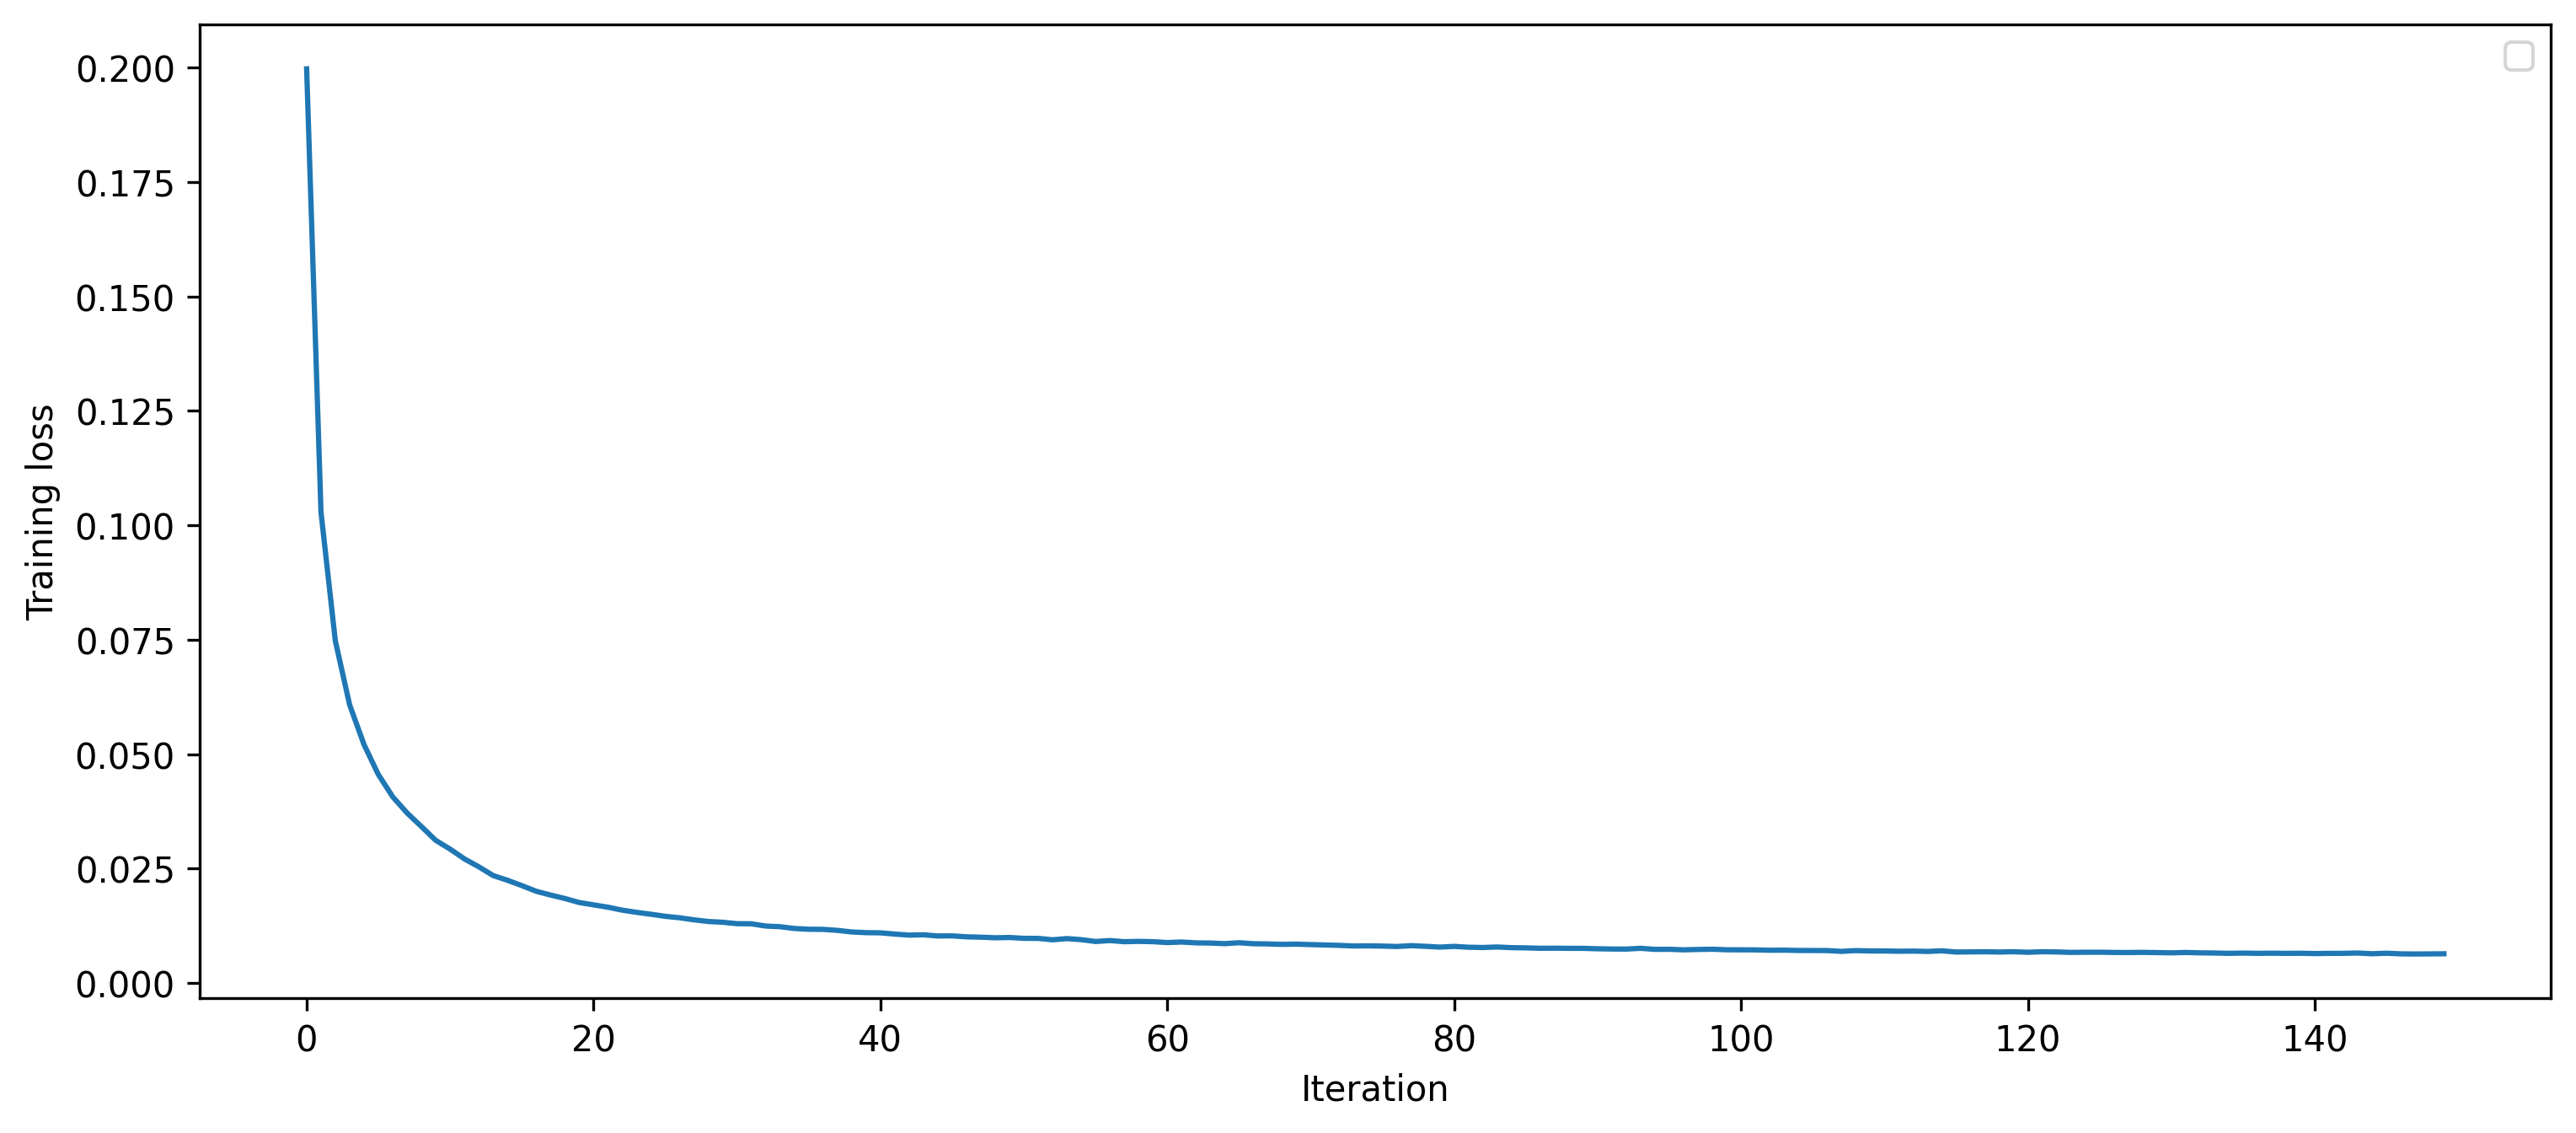

In [12]:
plt.figure(figsize=(12,5), dpi=300)
plt.plot(range(len(Loss_train)), Loss_train)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.legend()

In [13]:
torch.save(model.state_dict(), './result/model/MLP.pth')

# Evaluation

In [14]:
from scipy.integrate import solve_ivp
model.eval()
T = 6
FaultDuration=125
model.to("cpu")
def fun(t, np_x):
    x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32)
    dx = model.forward(None, x).data.numpy().reshape(-1)
    return dx
t_eval, X_test, y_test = getTestData(FaultDuration=FaultDuration)
t_eval = t_eval - t_eval[0]
t_eval = t_eval[:T*100]
t_span = [t_eval[0],t_eval[-1]]
y0 = X_test[1,:].numpy()
X_test_hat = solve_ivp(fun = fun, t_span=t_span, y0=y0, t_eval = t_eval)['y'].T
X_test = X_test[:T*100]


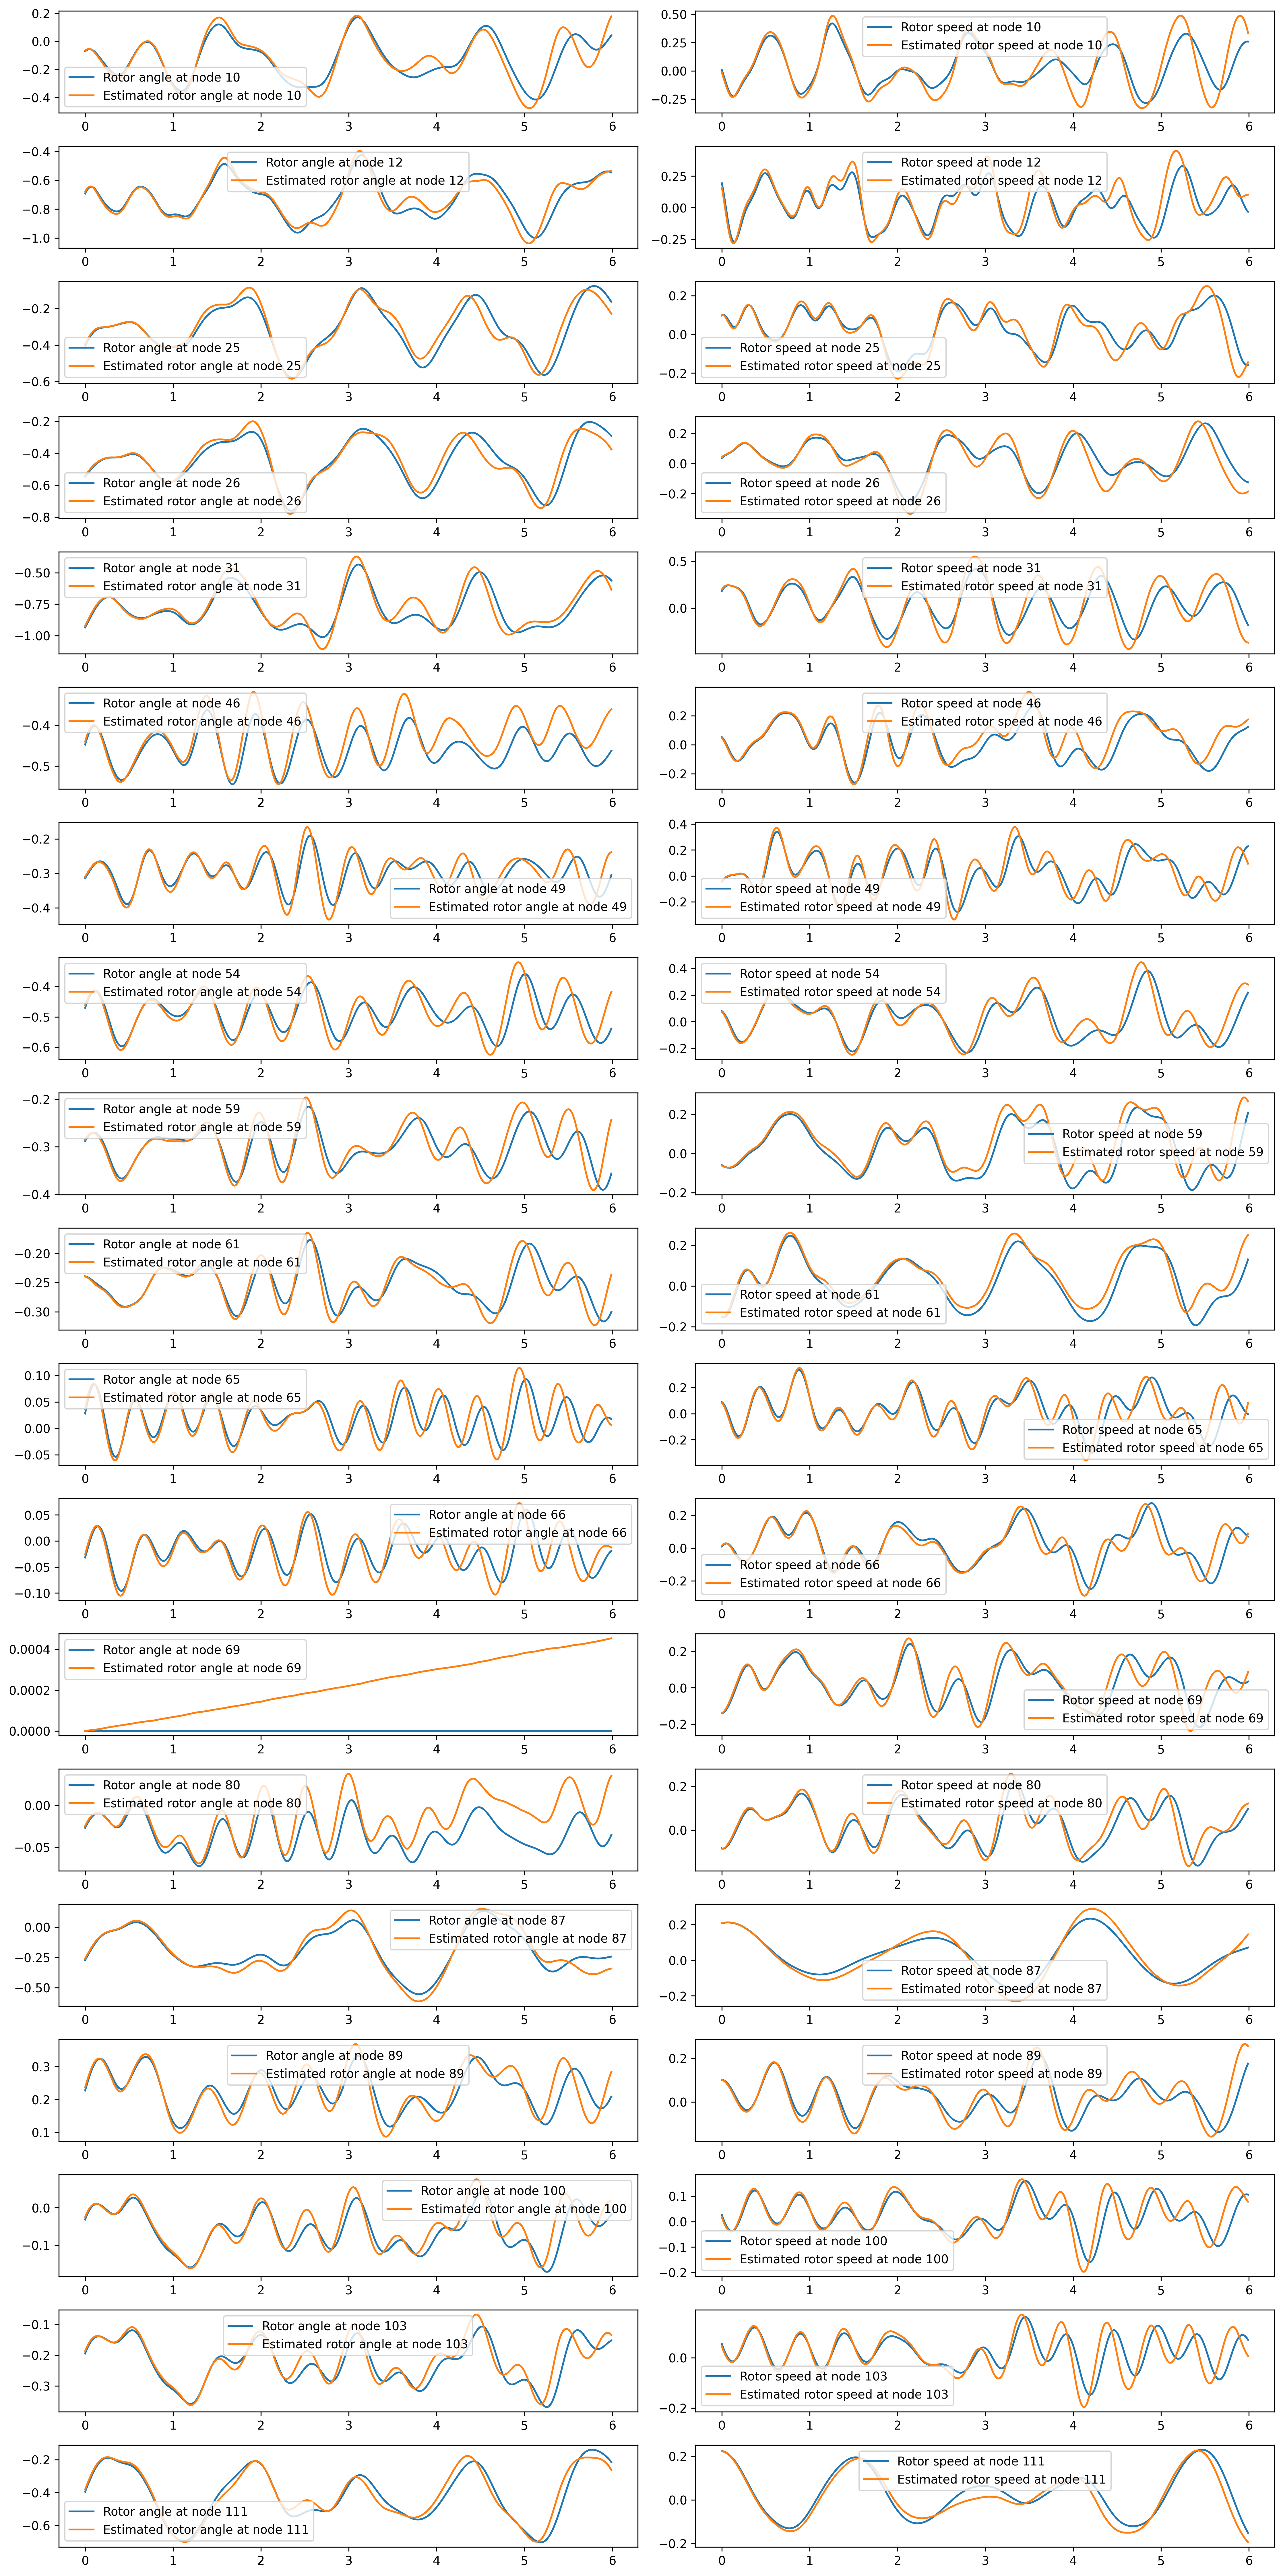

In [15]:
plt.figure(figsize=(15,30),dpi=300)
Generator_nodes = [10, 12, 25, 26, 31, 46, 49, 54, 59, 61, 65, 66, 69, 80, 87, 89, 100, 103, 111]
for i, node in enumerate(Generator_nodes):
    plt.subplot(19,2,2 * i + 1)
    plt.plot(t_eval, X_test[:,2 * i], label="Rotor angle at node {}".format(node))
    plt.plot(t_eval, X_test_hat[:,2 * i], label="Estimated rotor angle at node {}".format(node))
    plt.legend()
    plt.subplot(19,2,2 * i + 2)
    plt.plot(t_eval, X_test[:,2 * i + 1], label="Rotor speed at node {}".format(node))
    plt.plot(t_eval, X_test_hat[:,2 * i + 1], label="Estimated rotor speed at node {}".format(node))
    plt.legend()
plt.tight_layout()
plt.savefig("./result/test result/MLP-FaultDuration{}".format(FaultDuration))